# <u>Convolutional Neural Network</u>

Le Convolutional Neural Network, aussi appelé CNN ou Convnet,
est un type de réseau de neurones qui permet un traitement convolutif d'images,
c'est à dire des régions d'images.
Le but est de prétraiter des petites quantités d'informations.
Les réseaux neuronaux convolutifs sont populaires pour leur capacité à traiter 
efficacement la reconnaissance d'image et de vidéo.
<br>
<img src="https://miro.medium.com/max/2510/1*vkQ0hXDaQv57sALXAJquxA.jpeg"></img>
<small><small>Source : https://miro.medium.com/</small></small>
<br>

Dans le cadre de Tensorflow, on peut créer des modèles CNN grâce à la 
classe `Sequential()` mais surtout en y ajoutant des `Conv2D()` 
qui vont nous permettre de gérer un certain nombre de filtre par image ainsi 
que la taille de nos noyaux. De plus, nous y ajouterons également des couches de 
`MaxPool2D()` qui réduisent les données d'image sans en modifier la profondeur de sortie. 
Pour notre couche de sortie, nous suiverons le même principe que le perceptron multi-couches 
en utilisant une couche `Dense()` pour avoir 10 résultats en sortie en utilisant la fonction 
d'activation `softmax`.

Pour suivre l'example de nos modèles MLP et suite à des expérimentations nous utiliserons également du Dropout pour éviter un overfit trop important.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0

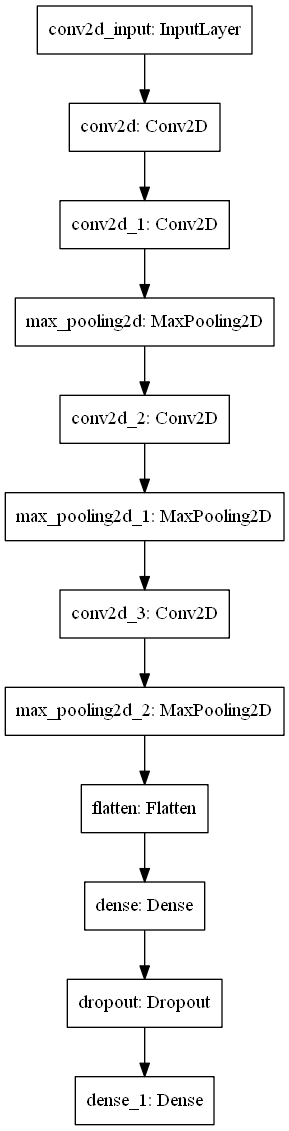

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.utils import plot_model

model = Sequential()

model.add(Conv2D(64, (3,3), padding="same", activation=relu, input_shape=(32,32,3)))
model.add(Conv2D(64, (3,3), padding="same", activation=relu))
model.add(MaxPool2D(2,2))
model.add(Conv2D(32, (3,3), padding="same", activation=relu))
model.add(MaxPool2D(2,2))
model.add(Conv2D(32, (3,3), padding="same", activation=relu))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dense(256, activation=relu))
model.add(Dropout(0.5))
model.add(Dense(10, activation=softmax))
model.compile(
    optimizer="adam", 
    loss=sparse_categorical_crossentropy,
    metrics=[sparse_categorical_accuracy]
)
model.build()
model.summary()
plot_model(model,to_file="./img/convnet.png")

En exécutant ceci :
```
import sys
sys.path.insert(1, '..') # allow import from parent folder
from src.cifar10 import Cifar10

cifar10 = Cifar10(dim=3)

cifar10.helper.fit(
    model,
    cifar10.x_train,
    cifar10.y_train,
    1024,
    100,
    validation_data=(cifar10.x_test, cifar10.y_test),
    process_name="convnet"
)
```

Voilà ce que nous obtenons :

In [2]:
from src.helper import Helper
Helper().read_log("convnet_4")

=====convnet_4=====
Epoch 1 - loss: 2.0087750416564942 ; sparse_categorical_accuracy : 0.258760005235672 ; val_loss : 1.6917589582443238 ; val_sparse_categorical_accuracy : 0.3889000117778778
Epoch 2 - loss: 1.6344657053756715 ; sparse_categorical_accuracy : 0.39851999282836914 ; val_loss : 1.4729678243637085 ; val_sparse_categorical_accuracy : 0.46299999952316284
Epoch 3 - loss: 1.4877963590621948 ; sparse_categorical_accuracy : 0.4565199911594391 ; val_loss : 1.4119527490615844 ; val_sparse_categorical_accuracy : 0.4957999885082245
Epoch 4 - loss: 1.3933758646392822 ; sparse_categorical_accuracy : 0.4966999888420105 ; val_loss : 1.2670770963668823 ; val_sparse_categorical_accuracy : 0.5401999950408936
Epoch 5 - loss: 1.296054399833679 ; sparse_categorical_accuracy : 0.5364000201225281 ; val_loss : 1.2078482280731202 ; val_sparse_categorical_accuracy : 0.5684000253677368
Epoch 6 - loss: 1.2349724238967896 ; sparse_categorical_accuracy : 0.5582200288772583 ; val_loss : 1.14025694713592

Nous observons alors que nous avons une précision supérieure que lorsque nous
faisions un MLP classique. Cependant le score est sûrement diminué à cause de 
l'underfitting global de ce modèle. L'entrainement a été arrêté en avance car avons
remarqué qu'il commençait à overfit.
Le temps d'exécution est cependant bien plus long avec un convnet qu'avec un MLP.

Pour corriger le problème de temps d'exécution, nous avons également ajouté un 
système d'arrêt anticipé avec le callback `EarlyStopping` de keras.

In [3]:
import tensorflow as tf
# Ajouté dans notre fonction `fit()` dans helper.py
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_sparse_categorical_accuracy",
    min_delta=0.0001,
    patience=1
)

Après avoir lancé plusieurs entraînements de modèles, nous observons que
nous avons une précision encore meilleure.
Qui se situe entre 60% et 75%. On peut donc en conclure que dans le cadre des images,
nous arrivons à encore mieux différencier nos classes. Cela est dû au fait que notre
modèle fait de la reconnaissance de "features", et qu'on peut considérer ce type 
d'entrainement comme plus efficace qu'un réseau de neurones classique qui prendra 
directement des pixels en entrée.

En utilisant la fonction utilisée après avoir lancé un scenario d'entrainements, on peut voir
le score de nos meilleurs modèles convnet générés :

In [4]:
from src.helper import Helper

helper = Helper()
best_convnet_models = helper.evaluate_models(10, "convnet")

In [5]:
best_convnet_models

[('convnet_2', 15.083199662489315),
 ('convnet_31', 14.609647667562774),
 ('convnet_30', 14.572673098181928),
 ('convnet_4', 14.459470080293148),
 ('convnet_68', 14.229722836366664),
 ('convnet_25', 14.18847273898768),
 ('convnet_6', 14.107114394814017),
 ('convnet_41', 13.935853388124842),
 ('convnet_37', 13.898582188309854),
 ('convnet_11', 13.868539978307009)]

In [6]:
helper.details(best_convnet_models)

{'convnet_2': {'score': 15.083199662489315,
  'acc': '77.07%',
  'loss': '0.6500975021553039',
  'val_acc': '80.52%',
  'val_loss': '0.554096814918518',
  'state': 'underfitting'},
 'convnet_31': {'score': 14.609647667562774,
  'acc': '77.05%',
  'loss': '0.6538646300888061',
  'val_acc': '74.35%',
  'val_loss': '0.7445753907203674',
  'state': 'overfitting'},
 'convnet_30': {'score': 14.572673098181928,
  'acc': '82.20%',
  'loss': '0.4993890814399719',
  'val_acc': '75.81%',
  'val_loss': '0.7221537199020386',
  'state': 'overfitting'},
 'convnet_4': {'score': 14.459470080293148,
  'acc': '86.72%',
  'loss': '0.36262259888648984',
  'val_acc': '76.72%',
  'val_loss': '0.7693597153663635',
  'state': 'overfitting'},
 'convnet_68': {'score': 14.229722836366664,
  'acc': '72.60%',
  'loss': '0.7779385518264771',
  'val_acc': '75.63%',
  'val_loss': '0.6892469040870667',
  'state': 'underfitting'},
 'convnet_25': {'score': 14.18847273898768,
  'acc': '75.22%',
  'loss': '0.71993740648269

## Conclusion

Les Convolutional Neural Networks proposent réellement un gros avantage dans la reconnaissance
d'image, notamment du fait qu'ils proposent de prendre en compte les features ce qui
facilite grandement les temps de traitement. 

On apprécie également les résultats, qui sont encore meilleurs que ceux observés avec des
modèles MLP. Nous trouverons malgré tout que le temps d'entraînement est encore plus long
sans une carte graphique adéquate et que les noyaux de convolutions nécessitent réellement des
ressources machines.

Nous verrons alors avec les ResNet une autre approche qui nous permet de comprendre encore mieux ce
qui est possible d'améliorer avec les ResNet.